In [28]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 65
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
import math
import warnings
import itertools
from statsmodels.tsa.api import Holt
from scipy.optimize import curve_fit
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#simple linear regression
def CI_PI_simple_regression(x, y, x1, a):
    x_new = np.array([1, x1])
    print("make CI and PI predictions at mean of x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    lower_bound2 = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound2 = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval2 = t_plus * (result_reg.mse_resid ** 0.5) * core2
    print("confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI
def c_of_c_test(r, n):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(0.975, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value
def Normality(SD):
    print('Normality test for errors using Shapiro Test')
    print(' - H0: Errors are normally distributed.')
    print(' - H1: Errors are not normally distributed.\n')
    stat, p = stats.shapiro(SD)
    print('pvalue of Shapiro Test =', p)
    if p < 0.05:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')
    else:
        print('\nSince p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
def Homoscedasticity(data, xlabel):
    print('Homoscedasticity Test')
    print(' - H0: Homoscedasticity')
    print(' - H1: Heteroscedasticity\n')
    y_pre = data[:, 2]
    SD = data[:, 10]
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(xlabel)
    plt.ylabel('Standardized Residual')
    plt.show()
def Randomness(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')    
    SD_median = statistics.median(SD)    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')
def Outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    ids = outliers.index
    ids = [n+1 for n in ids]
    
    print("Outliers by SD = \n")
    print(outliers)
    
    if len(ids)== 0:
        print("\nThere isnt any oulier.")
    else:
        print("\nSample", ids, "are outliers.")
def Influential(x_data, y_data):
    x_data = x_data.values
    y_data = y_data.values
    cov_mat = np.cov(y_data, x_data)
    x_data_bar = x_data.mean()
    data_nobs = len(x_data)
    h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
    df = pd.DataFrame(h_val,columns = ['hi'])
    filter = (df['hi'] > 6 / data_nobs )
    influs = df['hi'].loc[filter]
    ids = influs.index
    ids = [n+1 for n in ids]
    
    print("Influential Observations by hi = \n")
    print(influs)
    
    if len(ids)== 0:
        print("\nThere isn't any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")
def CI_PI_regression(xdata, yval, x1, a): #多變數的
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5

    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    
    CI = [lower_bound, upper_bound]
    PI = [lower_bound2, upper_bound2]
    return CI, PI
#multiple
def runtest(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')
    
    SD_median = statistics.median(SD)
    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median: 
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(1, len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')
def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)
def Chi_Square_for_Normality(stand_res, N, a): 
    m = np.mean(stand_res)
    s = np.std(stand_res)
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s
    counts, bins = np.histogram(stand_res, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]   
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e)
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = freq_o.shape[0]-3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    
    return chi_pval
def objective(x, a, b, c):
    return a * x + b * x**2 + c
def scatter_plot(x, y, data):
    y_var = data[y].values
    for i, aname in enumerate(x):
        x_var = data[aname].values
        _ = sns.regplot(x = x_var, y = y_var, color = 'b', ci = None)
        plt.title('Scatter Plot for '+y +' and ' +aname)
        plt.ylabel(y)
        plt.xlabel(aname)
        plt.show()
def scatter_plot_2nd(x, y, data):
    y_var = data[y].values
    color = ['r', 'b', 'g', 'c', 'm', 'y']
    for i, aname in enumerate(x):
        x_var = data[aname].values
        popt, _ = curve_fit(objective, x_var, y_var)
        a, b, c = popt
        print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
        plt.scatter(x_var, y_var, color = color[i], label=aname)
        x_line = np.arange(min(x_var), max(x_var), 0.1)
        y_line = objective(x_line, a, b, c)
        plt.plot(x_line, y_line, '--', color=color[i])
    plt.ylabel(y)
    plt.legend()
    plt.show()
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    return result6b
# Moving Average Forecasting
def MAF(y_v, p):
    ma_p_a = np.zeros(len(y_v) + 1)
    ma_p_a[:] = np.nan
    mvlen = p
    for i in range(mvlen, len(y_v) + 1):
        ma_p_a[i] = np.mean(y_v[i-mvlen: i])
    #print(ma_p_a)
    #print('len(ma_p_a)', len(ma_p_a))
    t1 = range(0, len(y_v) + 1) + np.ones((len(y_v) + 1))
    #print('len(t1)', len(t1))
    org_data = np.append(y_v, [np.nan])
    #print('len(org_data)', len(org_data))
    ma_df_p = pd.DataFrame({'time':t1, 'orig': org_data, 'ma_forecast': ma_p_a})
    return {"ma_forecast":ma_df_p}

# Exponential Smoothing Forecasting
def ExSm(y_v, a):
    es_df = pd.DataFrame({'orig': y_v})
    es_df['es_res'] = es_df['orig'].ewm(alpha = a, adjust= False).mean()
    es_al_a = np.zeros(len(y_v) + 1)
    es_al_a[0] = es_df['es_res'][0]
    es_al_a[1] = es_df['es_res'][0]
    for i in range(2, len(y_v) + 1):
        es_al_a[i] = es_df['es_res'][i-1]
    #print(es_al_a)
    t1 = range(0, len(y_v) + 1) + np.ones((len(y_v) + 1))
    org_data = y_v.tolist()
    es_df_e = pd.DataFrame({'time':t1, 'orig': np.array(org_data + [float('nan')]), 'es_forecast': es_al_a})
    return {"es_forecast":es_df_e}

# Holt's Two Parameter Exponential Smoothing
def ESM(y_v, a, b, f0, t0, p):
    esm_a = np.array(y_v)
    esm_model = Holt(esm_a, initialization_method='known', initial_level = f0, initial_trend = t0).fit(smoothing_level=a, smoothing_trend=b, optimized=False)
    esm_fit = esm_model.fittedvalues
    #print(esm_fit)
    esm_fcast = esm_model.forecast(p)
    #print(esm_fcast)
    esm_ab_a = np.zeros(len(y_v) + p + 1)
    esm_ab_a[0] = f0 + t0
    for i in range(1, len(y_v) + 1):
        esm_ab_a[i] = esm_fit[i-1]
    for i in range(len(y_v) + 1, len(y_v) + p + 1):
        esm_ab_a[i] = esm_fcast[i-len(y_v)-1]
    #print('esm_ab_a', esm_ab_a)
    t1 = range(0, len(y_v) + p + 1)
    #print('t1', t1)
    Ini_v = f0 + t0
    W_ini_v = np.append(Ini_v, y_v)
    org_data = np.append(W_ini_v, [np.nan]*p)
    wsm_df_ab = pd.DataFrame({'time':t1, 'orig': org_data, 'esm_forecast': esm_ab_a})
    return {"esm_forecast":wsm_df_ab}

# Error Metrix
def ErrMetrix(y_v, f_v):
    y_v_n = pd.DataFrame({'orig': y_v})
    f_v_n = pd.DataFrame({'forecast': f_v})
    err1 = (y_v_n['orig'] - f_v_n['forecast']).dropna().values
    err1p = ((y_v_n['orig'] - f_v_n['forecast'])/ y_v_n['orig']).dropna().values
    MAD = round(np.absolute(err1).mean(),6)
    MSE = round(np.mean(err1 * err1),6)
    RMSE = round(np.sqrt(np.mean(err1 * err1)),6)
    MAPE = round(np.absolute(err1p).mean() * 100, 6)
    print("MAD = ", MAD)
    print("MSE = ", MSE)
    print("RMSE = ", RMSE)
    print("MAPE = ", MAPE, "%")
    return MAD, MSE, RMSE, MAPE
#seasonal
def SI_MA(y_v, n):
    y_v_MA_a = np.zeros(len(y_v))
    y_v_MA_a[:] = np.nan
    mvlen = n
    if n % 2 == 0:
        halfwin = int(mvlen / 2)
        y_v_MA_ta = np.zeros(len(y_v))
        for i in range(halfwin, len(y_v) - halfwin + 1):
            y_v_MA_ta[i] = np.mean(y_v[(i-halfwin): (i+halfwin)])
        for ii in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[ii] = np.mean(y_v_MA_ta[(ii): (ii+2)])
    else:
        halfwin = int((mvlen - 1) / 2)
        for i in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[i] = np.mean(y_v[(i-halfwin): (i+halfwin+1)])
    SI_MA_a = np.zeros(len(y_v))
    SI_MA_a[:] = np.nan
    SI_MA_a = y_v / y_v_MA_a    
    SI_id_s = np.arange(1,len(y_v)+1)
    SI_id = SI_id_s - np.floor(SI_id_s / n) * n
    SI_id[np.where((SI_id[:] == 0))] = n
    SI_MA_a_df = pd.DataFrame({'SIMA': SI_MA_a, 'SIid': SI_id})
    SI_MA_u = np.zeros(n)
    for j in range(1,n+1):
        SI_MA_u[j-1] = SI_MA_a_df['SIMA'][SI_MA_a_df['SIid'] == j].dropna().mean()  
    SI_MA = SI_MA_u / sum(SI_MA_u) * n
    print('Seasonal Index:', SI_MA)  
    y_v_SI_MA = np.zeros(len(y_v))
    DSI_y_v = np.zeros(len(y_v))
    for k in range(0,len(y_v)):
        Idd = int(SI_MA_a_df['SIid'][k] - 1)
        y_v_SI_MA[k] = SI_MA[Idd]
        DSI_y_v[k] = y_v[k] / SI_MA[Idd]
    print('Deseasonalized Data:', DSI_y_v)
    SI_MA_result_a = np.array([SI_MA_a_df['SIid'], y_v_SI_MA, y_v, DSI_y_v])
    SI_MA_result_df = pd.DataFrame(SI_MA_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
    return {"ma_ind":SI_MA, "SI_MA_res":SI_MA_result_df}
def SI_LR(y_v, n):
    y_data = y_v
    X_data_ar = np.arange(1, len(y_v)+1)
    X_data_T = X_data_ar.T
    X_data = pd.DataFrame(X_data_T,columns = ['Time'])
    X_data = sm.add_constant(X_data)
    olsmod = sm.OLS(y_data, X_data)
    result_reg = olsmod.fit()
    st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
    y_v_LR_a = data[:, 2]
    SI_LR_a = y_v / y_v_LR_a
    SI_id_s = np.arange(1,len(y_v)+1)
    SI_id = SI_id_s - np.floor(SI_id_s / n) * n
    SI_id[np.where((SI_id[:] == 0))] = n
    SI_LR_a_df = pd.DataFrame({'SILR': SI_LR_a, 'SIid': SI_id})
    SI_LR_u = np.zeros(n)
    for j in range(1,n+1):
        SI_LR_u[j-1] = SI_LR_a_df['SILR'][SI_LR_a_df['SIid'] == j].dropna().mean()
    SI_LR = SI_LR_u / sum(SI_LR_u) * n
    print('Seasonal Index:', SI_LR)
    print('\n')
    y_v_SI_LR = np.zeros(len(y_v))
    DSI_y_v = np.zeros(len(y_v))
    for k in range(0,len(y_v)):
        Idd = int(SI_LR_a_df['SIid'][k] - 1)
        y_v_SI_LR[k] = SI_LR[Idd]
        DSI_y_v[k] = y_v[k] / SI_LR[Idd]
    print('Deseasonalized Data:', DSI_y_v)
    SI_LR_result_a = np.array([SI_LR_a_df['SIid'], y_v_SI_LR, y_v, DSI_y_v])
    SI_LR_result_df = pd.DataFrame(SI_LR_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
    return {"LR_ind":SI_LR, "SI_LR_res":SI_LR_result_df}

In [29]:
df17_1 = pd.read_excel('Stat_2020_2_Fin.xlsx', sheet_name = 'January')
display(df17_1.head())
display(df17_1.tail())

,Home,Heating_Cost,Temperature,Insulation,Age,Garage
0,1,250,35,3,6,0
1,2,360,29,4,10,1
2,3,165,36,7,3,0
3,4,43,60,6,9,0
4,5,92,65,5,6,0


,Home,Heating_Cost,Temperature,Insulation,Age,Garage
15,16,272,20,5,8,1
16,17,94,58,7,3,0
17,18,190,40,8,11,1
18,19,235,27,9,8,0
19,20,139,30,7,5,0


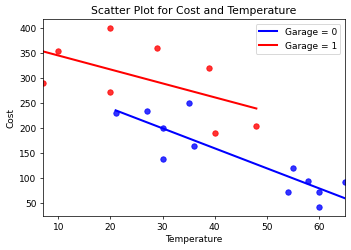

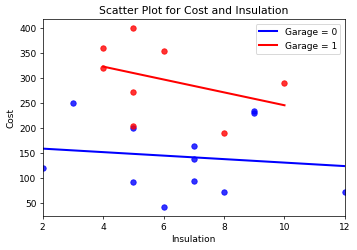

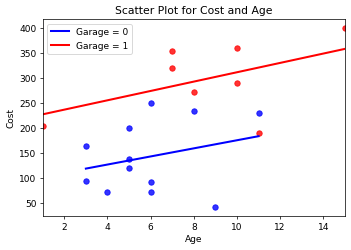

According to the scatter plot, all independet variables seem to have linear relationship with Cost.


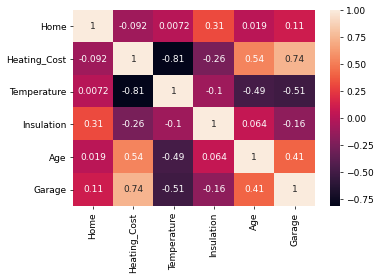

In [30]:
df17_1_0 = df17_1[df17_1.Garage == 0]
df17_1_1 = df17_1[df17_1.Garage == 1]
y_var = df17_1['Heating_Cost'].values
for xname in df17_1.columns[2:5]:
    x_var = df17_1[xname].values
    _ = sns.regplot(x = xname, y = 'Heating_Cost', data = df17_1_0, color = 'b', ci = None)
    _ = sns.regplot(x = xname, y = 'Heating_Cost', data = df17_1_1, color = 'r', ci = None)
    plt.xlabel(xname)
    plt.ylabel('Cost')
    plt.legend(labels=['Garage = 0', 'Garage = 1'])
    plt.title('Scatter Plot for Cost and ' +xname)
    plt.show()
print("According to the scatter plot, all independet variables seem to have linear relationship with Cost.")
df17_1a = df17_1[df17_1.columns]
corr1 = df17_1a.corr()
_ = sns.heatmap(corr1, annot=True)

In [31]:
# calcualte coefficient
y_data = df17_1['Heating_Cost']
X_data_ar = np.array([df17_1['Temperature'], df17_1['Insulation'], df17_1['Age'], df17_1['Garage']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df17_1.columns[2:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())
b1_3 = result_reg.params[3]
b1_2 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0_1, b1_1, b1_2, b1_3))
print("standard error = ", result_reg.mse_resid ** 0.5)#It is an estimate of the standard deviation of the error variable.
r2 = result_reg.rsquared
print("r^2 = ", r2)#24%能被解釋
r2_adj = result_reg.rsquared_adj
print("adjusted r^2 = ", r2_adj)#It differs because it includes an adjustment for the number of independent variables


                            OLS Regression Results                            
Dep. Variable:           Heating_Cost   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     27.57
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           9.27e-07
Time:                        13:16:50   Log-Likelihood:                -99.882
No. Observations:                  20   AIC:                             209.8
Df Residuals:                      15   BIC:                             214.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         361.7461     52.590      6.879      

**Test whether each of the independent variables is linearly related to the price of the lot in this model.**<br>
H0: βi = 0 for i = 1, 2, 3,4<br>
H1: βi ≠ 0 for i = 1, 2, 3,4<br>
According to the OLS Regression Results Summary Table,<br>
i = 1: pvalue of lot size = 0.216 > 0.05. We do not reject H0.<br>
i = 2: pvalue of Trees = 0.004 < 0.05. We reject H0.<br>
i = 3: pvalue of Distance = 0.058 > 0.05. We do not reject H0.<br>
Thus, only for the number of trees is there enough evidence to infer a linear relationship with price.
<br>no multicollinearity

Shapiro Test
Statistics=0.915, p=0.080


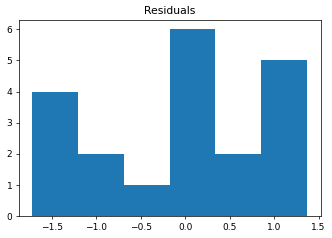

In [32]:
#residuals
st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
y_pre = data[:, 2]
SD = data[:, 10]
fig = plt.hist(SD, bins='auto')
plt.title('Residuals')
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))


Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.07969887554645538

Since p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.
Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



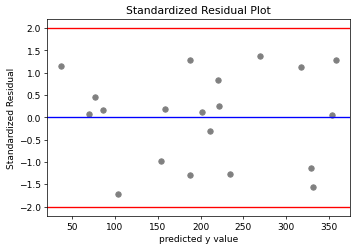

We do not reject H0. We can assume the variation is constant and the mean is around 0.
Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  15
n1 =  11
n2 =  10
Since both n1 and n2 < 20, we check the Run Test table.
Since k1=6 < 15 < k2=17, Randomness exist
Outliers by SD = 

Series([], Name: SD, dtype: float64)

There isnt any oulier.
Method 1:
h_level =  0.75
Influential Observations by hi = 
Series([], Name: hii, dtype: float64)

Method 2:
Influential Observations by Cook's Distances = 
Series([], Name: CD, dtype: float64)


In [33]:
Normality(SD)
Homoscedasticity(data,"predicted y value") #後面是xlabel隨便打
print("We do not reject H0. We can assume the variation is constant and the mean is around 0.")
Randomness(SD)
print("Since k1=6 < 15 < k2=17, Randomness exist")
Outlier(SD)
#influ比較麻煩
print("Method 1:")
X_data2 = np.array(X_data2)
H = np.matmul(X_data2, np.linalg.solve(np.matmul(X_data2.T, X_data2), X_data2.T))
df17_1['hii'] = np.diagonal(H)
df_h = pd.DataFrame(df17_1['hii'])
k = result_reg.df_model
n = len(df_h['hii'])
h_level = 3 * (k+1) / n 
print("h_level = ", h_level)
filter = (df_h['hii'] > h_level )
print("Influential Observations by hi = ")
print(df_h['hii'].loc[filter])

print("\nMethod 2:")
s2_e = result_reg.mse_resid
k = result_reg.df_model
y_a = data[:, 1]
y_f = data[:, 2]
h_i = df17_1['hii']
CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * h_i / np.square(1 - h_i)
CD = np.array(CD_arr)
df_cd = pd.DataFrame(CD,columns = ['CD'])
# display(df_cd.head())
filter = (df_cd['CD'] > 1 )
print("Influential Observations by Cook's Distances = ")
print(df_cd['CD'].loc[filter])

In [24]:
x1 = [1,30,5,10,0]
CI, PI = CI_PI_regression(X_data_ar, y_data, x1, 0.05)
print("Predicted sell = ", PI, "(thousand dollar)") #問CI則改CI

Predicted sell =  [132.48460146499073, 328.4023475355564] (thousand dollar)
